In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.linalg import eigh, inv
import matplotlib.path as mpath
from scipy.stats import gaussian_kde, iqr
from scipy.spatial.distance import mahalanobis, euclidean, cosine, cityblock, chebyshev
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy import stats

def load_process_tcga(cancer_name):
    """
    Function use:
    Load and Processes TCGA cancer data 
    
    Inputs:
    - cancer name 

    Outputs:
    - DataFrame of cleaned and labeled clinical manifest, or None if file already exists.
    """
    base_path = f'./data/TCGA_GeneExpression/{cancer_name}/'
    output_path = os.path.join(base_path, 'clean_expression_data.csv')

    if os.path.exists(output_path):
        print(f"loading data: {output_path}")
        return pd.read_csv(output_path)

    print(f"[proccessing] data for: {cancer_name}")

    gene_names = ["OGT", "OGA"]

    clinical_manifest = load_clinical_manifest(base_path)
    gene_exps, gene_key = load_dataframes(
        os.path.join(base_path, 'gene_expression.csv'),
        os.path.join(base_path, 'gene_key.csv')
    )

    gene_exps = gene_exps.apply(zscore, axis=1)

    clinical_manifest_duo = add_multiple_gene_expressions_to_clinical(
        gene_exps, clinical_manifest, gene_key, gene_names
    )
    clinical_manifest_duo = annotate_clinical_manifest(clinical_manifest_duo)

    clinical_manifest_duo.to_csv(output_path, index=False)
    print(f"Cleaned data saved to: {output_path}\n")

    return clinical_manifest_duo


def load_process_geo(geo, annot_path="./data/docs/GPL570.annot"):
    """
    Function use:
    Load and preprocess GEO gene data

    Inputs:
    - geo (str): GEO dataset ID (e.g., "GSEXXXXX").
    - annot_path (str): Path to the annotation file (GPL platform file).

    Outputs:
    - DataFrame: Cleaned DataFrame with sample IDs, sample types, and OGT/OGA expression.
    """
    clean_path = f"./data/GEO_GeneExpression/{geo}_relevant.csv"
    raw_path = f"./data/GEO_GeneExpression/{geo}.txt"

    if os.path.exists(clean_path):
        print("Clean file found. Loading...")
        return pd.read_csv(clean_path)

    print("Clean file not found. Processing from raw...")

    df = pd.read_csv(raw_path, sep="\t", dtype=str).dropna(how="all")
    df.iloc[:, 0:3] = df.iloc[:, 0:3].ffill()
    df = df[df["ID_REF"].notna()]
    expression_cols = df.columns[5:]
    df[expression_cols] = df[expression_cols].apply(pd.to_numeric, errors='coerce')

    melted = df.melt(
        id_vars=["!Sample_title", "!Sample_geo_accession", "!Sample_source_name_ch1", "ID_REF"],
        var_name="Sample", value_name="Expression"
    )

    pivoted = melted.pivot_table(index="Sample", columns="ID_REF", values="Expression")

    meta = df[["!Sample_title", "!Sample_geo_accession", "!Sample_source_name_ch1"]].drop_duplicates()
    meta = meta.rename(columns={
        "!Sample_geo_accession": "Sample",
        "!Sample_title": "Sample_title",
        "!Sample_source_name_ch1": "Sample_source_name"
    })

    final_df = meta.merge(pivoted, on="Sample", how="inner")

    annot = pd.read_csv(annot_path, sep="\t", comment='#', header=0, dtype=str, skiprows=27)
    valid_probes = [c for c in final_df.columns if c in annot["ID"].values]
    annot = annot[annot["ID"].isin(valid_probes)]

    probe_to_gene = annot[["ID", "Gene symbol"]].dropna()
    probe_to_gene = probe_to_gene[probe_to_gene["Gene symbol"] != ""]
    probe_to_gene = probe_to_gene.groupby("Gene symbol")["ID"].apply(list).to_dict()

    ogt_probes = probe_to_gene.get("OGT", [])

    gene_expr = {}
    for gene, probes in probe_to_gene.items():
        matching_cols = [p for p in probes if p in final_df.columns]
        if matching_cols:
            gene_expr[gene] = final_df[matching_cols].mean(axis=1)

    gene_expr_df = pd.DataFrame(gene_expr)
    gene_expr_df.index = final_df["Sample"]
    gene_expr_df = gene_expr_df.astype(float)
    gene_expr_z_df = gene_expr_df.apply(zscore, axis=0)

    ogt_expr = gene_expr_z_df.get("OGT")
    oga_expr = gene_expr_z_df.get("MGEA5")  # OGA  

    df_last = final_df[["Sample", "Sample_source_name"]].copy()
    df_last["OGT"] = ogt_expr.values if ogt_expr is not None else float("nan")
    df_last["OGA"] = oga_expr.values if oga_expr is not None else float("nan")
    df_last = df_last.drop_duplicates(subset=["Sample"], keep="first")

    df_last.to_csv(clean_path, index=False)
    print(f"Clean file generated and saved as {clean_path}.")
    return df_last


def classify_health_status_geo(sample_source):
    """
    Function use:
    Assign cancer/healthy label based on clinical data 
    
    Inputs:
    - cancer name 

    Outputs:
    - healhy/cancer label
    """
    sample_source = str(sample_source).strip()

    healthy_terms = {
        'leukemia class: Non-leukemia and healthy bone marrow',         # blood and bone marrow
        'tissue: normal kidney',                                        # kidney
        'Breast tissue, normal',                                        # breast
        'healthy',                                                      # thyroid 
        'normal',                                                       # lung 
        'stage: n/a'                                                    # Uterine
    }

    cancer_terms = {
        'leukemia class: mature B-ALL with t(8;14)',                    # blood and bone marrow
        'leukemia class: CLL','leukemia class: c-ALL/Pre-B-ALL without t(9;22)',       
        'leukemia class: AML with normal karyotype + other abnormalities',
        'leukemia class: MDS', 'leukemia class: c-ALL/Pre-B-ALL with t(9;22)',
        'leukemia class: T-ALL','leukemia class: CML','leukemia class: ALL with t(12;21)',
        'leukemia class: Pro-B-ALL with t(11q23)/MLL','leukemia class: AML with t(8;21)',
        'leukemia class: AML complex aberrant karyotype','leukemia class: AML with t(15;17)',
        'leukemia class: ALL with hyperdiploid karyotype','leukemia class: ALL with t(1;19)',
        'leukemia class: AML with t(11q23)/MLL','leukemia class: AML with inv(16)/t(16;16)',
        'tissue: clear cell renal cell carcinoma',                      # kidney
        'Breast tissue, cancer',                                        # breast
        'cancer',                                                       # thyroid
        'stage: I', 'stage: IA', 'stage: IB', 'stage: IC'               # uterine
    }

    if sample_source.startswith("Lung Cancer"):                         # lung
        return "Cancer"
    elif sample_source.startswith("Lung Normal"):
        return "Healthy"

    if sample_source in healthy_terms:
        return "Healthy"
    elif sample_source in cancer_terms:
        return "Cancer"
    else:
        return "Unknown"


def batch_correct_joint(tcga_list, geo_list, titles, plot_toggle=False):
    """
    Function use:
    batch correct geo data to be comparable to tcga datasets (cancer type based)
    
    Inputs:
    - tcga_list (list): list of tcga dataframes
    - geo_list (list): list of geo dataframes
    - titles (list): list of cancer types

    Outputs:
    - tcga_corrected (list): list of tcga dataframes
    - geo_corrected (list): list of batch corrected geo dataframes
    - plot showing batch correction
    """
    tcga_corrected, geo_corrected = [], []
    for idx, (tcga, geo) in enumerate(zip(tcga_list, geo_list)):
        tcga_df = tcga.copy()
        geo_df = geo.copy()
        
        # Initialize corrected columns
        geo_df['OGT_corrected'] = np.nan
        geo_df['OGA_corrected'] = np.nan
        
        for health_status in ['Healthy', 'Cancer']:
            tcga_mask = tcga_df['label'] == health_status
            geo_mask = geo_df['label'] == health_status
            
            if tcga_mask.sum() > 2 and geo_mask.sum() > 2:
                # Prepare joint data
                tcga_joint = tcga_df.loc[tcga_mask, ['OGT', 'OGA']].values
                geo_joint = geo_df.loc[geo_mask, ['OGT', 'OGA']].values
                
                # Apply joint correction
                corrected_joint = match_joint_distribution(geo_joint, tcga_joint)
                
                # Assign corrected values
                geo_df.loc[geo_mask, 'OGT_corrected'] = corrected_joint[:, 0]
                geo_df.loc[geo_mask, 'OGA_corrected'] = corrected_joint[:, 1]
        
        # Handle unclassified samples
        unclassified = geo_df['OGT_corrected'].isna()
        if unclassified.any():
            geo_df.loc[unclassified, ['OGT_corrected', 'OGA_corrected']] = \
                geo_df.loc[unclassified, ['OGT', 'OGA']].values
        
        # Visualization
        if plot_toggle:
            plot_batch_corrections(tcga_df, geo_df, titles[idx])
        
        # Update dataframe
        geo_df['OGT'] = geo_df['OGT_corrected']
        geo_df['OGA'] = geo_df['OGA_corrected']
        geo_corrected.append(geo_df.drop(['OGT_corrected', 'OGA_corrected'], axis=1))
        tcga_corrected.append(tcga_df)
    
    return tcga_corrected, geo_corrected

def match_joint_distribution(source, target):
    """
    Matches joint distribution using linear transformation to preserve covariance
    while aligning with target distribution. Returns corrected source distribution.
    """
    # Center data
    source_centered = source - np.mean(source, axis=0)
    target_centered = target - np.mean(target, axis=0)
    
    # Compute covariance matrices
    cov_source = np.cov(source_centered.T)
    cov_target = np.cov(target_centered.T)
    
    # Whitening transformation for source
    eigvals_source, eigvecs_source = eigh(cov_source)
    whitening_matrix = eigvecs_source @ np.diag(1/np.sqrt(eigvals_source)) @ eigvecs_source.T
    
    # Coloring transformation for target
    eigvals_target, eigvecs_target = eigh(cov_target)
    coloring_matrix = eigvecs_target @ np.diag(np.sqrt(eigvals_target)) @ eigvecs_target.T
    
    # Apply transformation
    whitened = source_centered @ whitening_matrix
    corrected = whitened @ coloring_matrix + np.mean(target, axis=0)
    
    return corrected

def plot_batch_corrections(tcga, geo, title):
    """Visualizes joint distribution correction results (TCGA vs GEO corrected only)."""
    fig, axs = plt.subplots(1, 2, figsize=(8,2))
    fig.suptitle(f"{title} - Joint Distribution Correction", fontsize=16)
    color_map = {'Healthy': 'blue', 'Cancer': 'red'}
    
    def plot_scatter(ax, df, x_col, y_col, plot_title):
        cancer_subset = df[df['label'] == 'Cancer']
        if not cancer_subset.empty:
            ax.scatter(cancer_subset[x_col], cancer_subset[y_col], c=color_map['Cancer'],
                       alpha=0.6, label='Cancer', s=20)
        healthy_subset = df[df['label'] == 'Healthy']
        if not healthy_subset.empty:
            ax.scatter(healthy_subset[x_col], healthy_subset[y_col], c=color_map['Healthy'],
                       alpha=0.8, label='Healthy', s=30, edgecolor='k')
        ax.set_title(plot_title)
        ax.legend()
        ax.grid(alpha=0.3)

    # Left: TCGA Reference
    plot_scatter(axs[0], tcga, 'OGA', 'OGT', 'TCGA Reference')

    # Right: GEO Corrected
    plot_scatter(axs[1], geo, 'OGA_corrected', 'OGT_corrected', 'GEO Corrected')

    # Ensure both plots use the same axis limits
    xlims = [min(ax.get_xlim()[0] for ax in axs), max(ax.get_xlim()[1] for ax in axs)]
    ylims = [min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)]
    for ax in axs:
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)

    plt.tight_layout()
    plt.show()

def merge_geo_pairs(tcga_list, geo_list, titles):
    """
    Merges specific named GEO dataframe pairs and updates titles and TCGA list accordingly.
    Combines: Kidney+Kidney2

    Returns:
        tuple: (new_tcga_list, new_geo_list, new_titles)
    """
    import pandas as pd

    # Define pairs to merge
    merge_pairs = [("Kidney", "Kidney2")]

    # Initialize new lists
    new_tcga_list = []
    new_geo_list = []
    new_titles = []

    skip_titles = {pair[1] for pair in merge_pairs}  

    i = 0
    while i < len(titles):
        title = titles[i]
        if title in skip_titles:
            i += 1
            continue

        # If title matches first in pair, look for second and merge GEO
        matching_pair = next((pair for pair in merge_pairs if pair[0] == title), None)
        if matching_pair:
            idx1 = titles.index(matching_pair[0])
            idx2 = titles.index(matching_pair[1])
            merged_geo = pd.concat([geo_list[idx1], geo_list[idx2]], ignore_index=True)
            new_geo_list.append(merged_geo)
        else:
            new_geo_list.append(geo_list[i])

        new_tcga_list.append(tcga_list[i])
        new_titles.append(titles[i])
        i += 1

    return new_tcga_list, new_geo_list, new_titles

def generate_TCGA_metrics(clinical_manifest, see_through=0.8, sensitivity_threshold=None, 
    remove_outliers=False, plot_verification_points=False, zoom_limits=None, lvls=30, title="", plot_toggle=False):
    """
    Generate all sample level metrics.

    Inputs:
    - ...

    Outputs:
    - ...
    """
    df = clinical_manifest.copy()
    ogt_column = 'OGT'
    oga_column = 'OGA'
    healthy_labels = ['Healthy']
    unhealthy_labels = ['Cancer']
    stage_labels = ['Cancer']

    def is_relevant_sample(label):
        if isinstance(label, str):
            if label in healthy_labels or label in unhealthy_labels:
                return True
            for stage in stage_labels:
                if label.startswith(stage):
                    return True
        return False

    df = df[df['label'].apply(is_relevant_sample)]
    df['Health_Status'] = df['label'].apply(lambda x: 'Healthy' if x in healthy_labels else 'Cancer')

    if remove_outliers:
        for col in [oga_column, ogt_column]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower) & (df[col] <= upper)]

    healthy_samples = df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]]
    
    if len(healthy_samples) > 1:
        mean_healthy = healthy_samples.mean().values
        cov_healthy = healthy_samples.cov().values
        inv_cov_healthy = inv(cov_healthy)

        dist_funcs = {
            'mahalanobis_distance': lambda p: mahalanobis(p, mean_healthy, inv_cov_healthy),
            'euclidean_distance': lambda p: euclidean(p, mean_healthy),
            'cosine_distance': lambda p: cosine(p, mean_healthy),
            'manhattan_distance': lambda p: cityblock(p, mean_healthy),
            'chebyshev_distance': lambda p: chebyshev(p, mean_healthy)
        }

        for name, func in dist_funcs.items():
            df[name] = [func(np.array([row[oga_column], row[ogt_column]])) for _, row in df.iterrows()]
    else:
        for name in ['mahalanobis_distance', 'euclidean_distance', 'cosine_distance', 'manhattan_distance', 'chebyshev_distance']:
            df[name] = np.nan

    if sensitivity_threshold is None:
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], 
                                df[df['Health_Status'] == 'Healthy'][ogt_column]])
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 2000)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)
        sensitivity_threshold = find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid)

    if not df.empty:
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], 
                                df[df['Health_Status'] == 'Healthy'][ogt_column]])
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 2000)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)

        zgrid_normalized = (zgrid_healthy - zgrid_healthy.min()) / (sensitivity_threshold - zgrid_healthy.min()) * 0.5
        zgrid_normalized[zgrid_normalized > 0.5] = 0.5

        zgrid_values = np.zeros_like(zgrid_healthy)
        zgrid_values[zgrid_healthy <= sensitivity_threshold] = zgrid_normalized[zgrid_healthy <= sensitivity_threshold]
        zgrid_values[zgrid_healthy > sensitivity_threshold] = 0.5 + ((zgrid_healthy[zgrid_healthy > sensitivity_threshold] - sensitivity_threshold) /
                                                                   (zgrid_healthy.max() - sensitivity_threshold)) * 0.5

        points = df[[oga_column, ogt_column]].values
        dysreg_scores = np.array([zgrid_values[np.abs(ygrid[:, 0] - y).argmin(), np.abs(xgrid[0, :] - x).argmin()] for x, y in points])
        df['O-GlcNAcylation dysregulation'] = dysreg_scores

        if plot_toggle:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Cancer'], color='red', alpha=see_through, label='Cancer')
            sns.scatterplot(x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Healthy'], color='blue', alpha=see_through, label='Healthy')
            plt.contourf(xgrid, ygrid, zgrid_normalized, levels=20, cmap='Greys', alpha=0.5)
            plt.contourf(xgrid, ygrid, zgrid_values, levels=lvls, cmap='viridis', alpha=0.5)

            if zoom_limits is not None:
                plt.xlim([0, zoom_limits[1]])
                plt.ylim([0, zoom_limits[0]])

            plt.title(f"{title}", fontsize=20)
            plt.xlabel(oga_column)
            plt.ylabel(ogt_column)
            plt.legend(title='Health Status', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.colorbar(label='KDE Regulation Score', shrink=0.60)

            avg_healthy = dysreg_scores[df['Health_Status'] == 'Healthy'].mean()
            avg_cancer = dysreg_scores[df['Health_Status'] == 'Cancer'].mean()
            plt.text(0.70, 0.95, 
                     f"  Average Regulation Score  \n\n"
                     f"Healthy: {avg_healthy:.2f} (n = {len(df[df['Health_Status'] == 'Healthy'])})\n"
                     f"Cancer: {avg_cancer:.2f} (n = {len(df[df['Health_Status'] == 'Cancer'])})",
                     transform=plt.gca().transAxes, fontsize=20, verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6))
            plt.tight_layout()
            plt.show()

    return df, sensitivity_threshold

def find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid):
    """
    Calculate the optimal sensitivity threshold for a given KDE distribution.

    Inputs:
    - zgrid_healthy (array): KDE values for healthy samples on a grid.
    - df (DataFrame): Input DataFrame containing sample points.
    - oga_column (str): Column name for OGA values.
    - ogt_column (str): Column name for OGT values.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.

    Outputs:
    - best_threshold (float): Optimal threshold value based on the KDE distribution.
    """
    thresholds = np.linspace(zgrid_healthy.min(), zgrid_healthy.max(), 500)# 2000)
    healthy_points = df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]].values
    best_thresholds = []
    best_diff = float('inf')

    for threshold in thresholds:
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[threshold], colors='black', linestyles='dashed')
        if contour.collections and contour.collections[0].get_paths():
            path = mpath.Path(contour.collections[0].get_paths()[0].vertices)
            inside = path.contains_points(healthy_points)
            inside_count = np.sum(inside)
            outside_count = len(healthy_points) - inside_count
            diff = abs(inside_count - outside_count)

            if diff < best_diff:
                best_diff = diff
                best_thresholds = [threshold]
            elif diff == best_diff:
                best_thresholds.append(threshold)
        
        plt.close()  

    if best_thresholds:
        best_threshold = best_thresholds[len(best_thresholds) // 2]
        return best_threshold
    else:
        print("No valid thresholds found, using default.")
        return thresholds[-1]

def plot_KDE_distributions(clinical_manifests, titles):
    """
    Compares the distributions of dysregulation scores between healthy and unhealthy tissue samples for statistical significance
    and plots the cumulative distributions.

    Inputs:
    - clinical_manifests: List of DataFrames with dysregulation scores already calculated.

    Outputs:
    - DataFrame with the cancer type, KS-statistic, KS p-value for each comparison.
    """
    results = []

    healthy_labels = ['Healthy']
    unhealthy_labels = ['Cancer']
    stage_labels = ['Cancer']
    group_columns = ['label']*len(clinical_manifests)

    for df, name in zip(clinical_manifests, titles):
        df.name = name

    def get_color(label, highlight_healthy):
        if isinstance(label, str):
            if highlight_healthy:
                if label in healthy_labels:
                    return 'blue'
                return 'lightgrey'
            else:
                if any(label.startswith(stage) for stage in stage_labels) or label in unhealthy_labels:
                    return 'red'
                return 'lightgrey'
        return 'lightgrey'

    num_plots = len(clinical_manifests)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8), constrained_layout=True)
    axes = axes.flatten()

    for i, (clinical_manifest, group_column) in enumerate(zip(clinical_manifests, group_columns)):
        df = clinical_manifest.copy()
        df = df[df['label'].apply(lambda x: isinstance(x, str) and (x in healthy_labels or any(x.startswith(stage) for stage in stage_labels) or x in unhealthy_labels))]
        df['color_healthy'] = df['label'].apply(lambda x: get_color(x, True))
        df['color_unhealthy'] = df['label'].apply(lambda x: get_color(x, False))

        # Get dysregulation scores
        healthy_dysreg = df[df['color_healthy'] == 'blue']['O-GlcNAcylation dysregulation'].values
        unhealthy_dysreg = df[df['color_unhealthy'] == 'red']['O-GlcNAcylation dysregulation'].values

        if len(healthy_dysreg) > 0 and len(unhealthy_dysreg) > 0:
            # Perform KS test
            ks_stat, ks_p_value = stats.ks_2samp(healthy_dysreg, unhealthy_dysreg)
    
            results.append({
                'Cancer Type': clinical_manifest.name,
                'KS-statistic': ks_stat,
                'KS p-value': ks_p_value,
            })

            # Plot cumulative distributions
            counts_healthy, bin_edges_healthy = np.histogram(healthy_dysreg, bins=50, density=True)
            cdf_healthy = np.cumsum(counts_healthy)
            cdf_healthy = cdf_healthy / cdf_healthy[-1]
            axes[i].plot(bin_edges_healthy[1:], cdf_healthy, color='blue', lw=2, label='Healthy', zorder=10)
            axes[i].fill_between(bin_edges_healthy[1:], cdf_healthy, color='blue', alpha=0.1, zorder=4)

            counts_unhealthy, bin_edges_unhealthy = np.histogram(unhealthy_dysreg, bins=50, density=True)
            cdf_unhealthy = np.cumsum(counts_unhealthy)
            cdf_unhealthy = cdf_unhealthy / cdf_unhealthy[-1]
            axes[i].plot(bin_edges_unhealthy[1:], cdf_unhealthy, color='red', lw=2, label='Cancer', zorder=5)
            axes[i].fill_between(bin_edges_unhealthy[1:], cdf_unhealthy, color='red', alpha=0.1, zorder=2)

            # Add the title and labels
            axes[i].set_title(f"{clinical_manifest.name}", fontsize=18)

            if i < num_cols:
                axes[i].set_xlabel('')
                axes[i].set_xticklabels([])
            else:
                axes[i].set_xlabel('Regulation Scores', fontsize=14)

            if i % num_cols == 0:
                axes[i].set_ylabel('Cumulative Probability', fontsize=14)
            else:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])

            axes[i].legend(loc='upper left', fontsize=12)

            # Add KS test result as text
            textstr = (f' \n'
                       f'KS statistic: {ks_stat:.2f}\n'
                       f'p-value: {ks_p_value:.2e}')
            axes[i].text(0.65, 0.30, textstr, transform=axes[i].transAxes, fontsize=16,
                         verticalalignment='top', horizontalalignment='center')

        # Remove grid lines
        axes[i].grid(False)

        # Cosmetic: set tick parameters and spines to match ROC formatting
        for spine in ['top', 'right']:
            axes[i].spines[spine].set_visible(False)
        axes[i].spines['left'].set_alpha(0.4)
        axes[i].spines['bottom'].set_alpha(0.4)
        axes[i].tick_params(axis='both', which='both', length=0)
        axes[i].set_aspect('auto')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.savefig('./data/figures/Fig3_Statistical_Comparison.png', dpi=600, bbox_inches='tight')
    plt.show()

    return pd.DataFrame(results)


def plot_KDE_regulation_scores(datasets, titles, geo_datasets=None, thresholds=None, label = 'Health_Status',
                                   see_through=0.8, zoom_limits=None, figsize=(16, 10), save_as = None):
    """
    Plots all OGT vs OGA heatmaps in a compact grid layout using provided sensitivity thresholds.
    Includes shared color bar and legend.

    Inputs:
    - datasets: List of DataFrames for each dataset.
    - titles: List of titles for each plot.
    - thresholds: List of predefined sensitivity thresholds for each dataset (if None, thresholds are calculated dynamically).
    - see_through: Transparency level for scatterplot points.
    - zoom_limits: List of zoom limits for each plot (optional).
    - figsize: Tuple specifying the overall figure size.

    Outputs:
    - Displays all plots in a single grid layout.
    """
    num_plots = len(datasets)
    num_cols = 3  
    num_rows = (num_plots + num_cols - 1) // num_cols  

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_rows, num_cols + 1, width_ratios=[1, 1, 1, 0.1], wspace=0.1, hspace=0.17)  

    cmap = 'viridis'  
    norm = Normalize(vmin=0, vmax=1) 
    darker = 0

    for i, (dataset, title) in enumerate(zip(datasets, titles)):
        row, col = divmod(i, num_cols)
        ax = fig.add_subplot(gs[row, col])
        df = dataset.copy()
        if geo_datasets != None:
            df_geo = geo_datasets[i].copy()
        ogt_column = 'OGT'
        oga_column = 'OGA'

        # Check if there are enough Healthy samples for KDE
        healthy_data = df[df[label] == 'Healthy']
        if len(healthy_data) < 2:
            ax.text(0.60, 0.5, "Insufficient Healthy Data", ha='center', va='center', fontsize=12)
            ax.set_title(title, fontsize=20)
            ax.set_xlim(0, zoom_limits[i][1] if zoom_limits and zoom_limits[i] else df[oga_column].max())
            ax.set_ylim(0, zoom_limits[i][0] if zoom_limits and zoom_limits[i] else df[ogt_column].max())
            continue

        # Prepare data for KDE
        xy_healthy = np.vstack([healthy_data[oga_column], healthy_data[ogt_column]])
        kde_healthy = gaussian_kde(xy_healthy)

        # Create grid
        if zoom_limits and zoom_limits[i]:
            x_min, x_max = 0, zoom_limits[i][1]
            y_min, y_max = 0, zoom_limits[i][0]
        else:
            x_min, x_max = df[oga_column].min(), df[oga_column].max()
            y_min, y_max = df[ogt_column].min(), df[ogt_column].max()
        x = np.linspace(x_min, x_max, 2000)
        y = np.linspace(y_min, y_max, 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        zgrid_healthy = kde_healthy(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)

        # Use predefined threshold if provided, otherwise calculate it
        if thresholds and len(thresholds) > i and thresholds[i] is not None:
            sensitivity_threshold = thresholds[i]
        else:
            sorted_density = np.sort(kde_healthy(xy_healthy))
            sensitivity_threshold = sorted_density[len(sorted_density) // 2]

        # Normalize the z-grid
        zgrid_healthy_normalized = np.zeros_like(zgrid_healthy)
        zgrid_healthy_normalized[zgrid_healthy <= sensitivity_threshold] = (
            (zgrid_healthy[zgrid_healthy <= sensitivity_threshold] - zgrid_healthy.min()) / 
            (sensitivity_threshold - zgrid_healthy.min()) * 0.5
        )
        zgrid_healthy_normalized[zgrid_healthy > sensitivity_threshold] = 0.5 + (
            (zgrid_healthy[zgrid_healthy > sensitivity_threshold] - sensitivity_threshold) / 
            (zgrid_healthy.max() - sensitivity_threshold) * 0.5
        )

        # Calculate dysregulation scores for each sample
        points = df[[oga_column, ogt_column]].values
        dysreg_scores = np.array([
            zgrid_healthy_normalized[
                np.abs(ygrid[:, 0] - y).argmin(), 
                np.abs(xgrid[0, :] - x).argmin()
            ] for x, y in points
        ])
        df['O-GlcNAcylation dysregulation'] = dysreg_scores

        # Compute mean dysregulation scores
        if geo_datasets != None: 
            avg_dysreg_healthy = df_geo[df_geo[label] == 'Healthy']['O-GlcNAcylation dysregulation'].mean()
            avg_dysreg_cancer = df_geo[df_geo[label] == 'Cancer']['O-GlcNAcylation dysregulation'].mean()
            # Add text with scores to the plot
            ax.text(
                0.42, 0.95, 
                f"Average Regulation Score\n\n"
                f"Healthy: {avg_dysreg_healthy:.2f} (n = {len(df_geo[df_geo[label] == 'Healthy'])})\n"
                f"Cancer: {avg_dysreg_cancer:.2f} (n = {len(df_geo[df_geo[label] == 'Cancer'])})",
                transform=ax.transAxes, fontsize=15, verticalalignment='top', horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.6)
            )
        else:
            avg_dysreg_healthy = df[df[label] == 'Healthy']['O-GlcNAcylation dysregulation'].mean()
            avg_dysreg_cancer = df[df[label] == 'Cancer']['O-GlcNAcylation dysregulation'].mean()

            # Add text with scores to the plot
            ax.text(
                0.42, 0.95, 
                f"Average Regulation Score\n\n"
                f"Healthy: {avg_dysreg_healthy:.2f} (n = {len(df[df[label] == 'Healthy'])})\n"
                f"Cancer: {avg_dysreg_cancer:.2f} (n = {len(df[df[label] == 'Cancer'])})",
                transform=ax.transAxes, fontsize=15, verticalalignment='top', horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.6)
            )
            
        darker += 0.008
        
        if geo_datasets != None: 
            # Plot scatter plots
            sns.scatterplot(
                x=oga_column, y=ogt_column, data=df_geo[df_geo[label] == 'Cancer'],
                color='red', alpha=see_through-0.005, ax=ax
            )
        else:
            sns.scatterplot(
                x=oga_column, y=ogt_column, data=df[df[label] == 'Cancer'],
                color='red', alpha=see_through-0.005, ax=ax
            )
            sns.scatterplot(
                x=oga_column, y=ogt_column, data=df[df[label] == 'Healthy'],
                color='blue', alpha=see_through+darker, ax=ax
            )

        # Plot heatmap and contour lines
        ax.contourf(xgrid, ygrid, zgrid_healthy_normalized, levels=30, cmap=cmap, alpha=0.5, norm=norm)
        # ax.contour(xgrid, ygrid, zgrid_healthy, levels=[sensitivity_threshold], colors='black', linestyles='dashed')

        if geo_datasets != None: 
            sns.scatterplot(
                x=oga_column, y=ogt_column, data=df_geo[df_geo[label] == 'Healthy'],
                color='blue', alpha=0.3, ax=ax
            )
            
        # Add title and zoom limits
        ax.set_title(title, fontsize=20)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Remove axis ticks and labels
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.grid(False)

    # Add shared color bar (shortened and positioned properly)
    cbar_ax = fig.add_subplot(gs[0:num_rows, -1])  # Last column for color bar
    cbar = fig.colorbar(
        ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax, orientation='vertical', fraction=0.9, pad=1, alpha = 0.5
    )
    # Adjust position explicitly
    pos = cbar_ax.get_position()
    cbar_ax.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height * 0.88])  # Shift up/down and adjust height
    cbar.set_label('Regulation Score', fontsize=14)
    cbar.set_label('Regulation Score', fontsize=14)

    # Add shared legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Healthy'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cancer')
    ]
    cbar_ax.legend(handles=legend_handles, loc='upper center', fontsize=12, title='Health Status', bbox_to_anchor=(1.4, 1.15))
    if save_as != None:
        plt.savefig(f'./data/figures/{save_as}.png', dpi=600, bbox_inches='tight')  

    plt.show()

def generate_GEO_metrics(geo_df, tcga_df, threshold, see_through=0.8, 
                         zoom_limits=None, title="", plot_toggle=False):

    geo = geo_df.copy()
    tcga = tcga_df.copy()
    ogt_column = 'OGT'
    oga_column = 'OGA'

    tcga_healthy = tcga[tcga['label'] == 'Healthy'][[oga_column, ogt_column]]
    mean_healthy = tcga_healthy.mean().values
    cov_healthy = tcga_healthy.cov().values
    try:
        inv_cov_healthy = inv(cov_healthy)
    except:
        inv_cov_healthy = np.linalg.pinv(cov_healthy)

    distances = {
        'mahalanobis_distance': [],
        'euclidean_distance': [],
        'cosine_distance': [],
        'manhattan_distance': [],
        'chebyshev_distance': []
    }

    for _, row in geo.iterrows():
        point = np.array([row[oga_column], row[ogt_column]])
        try:
            distances['mahalanobis_distance'].append(mahalanobis(point, mean_healthy, inv_cov_healthy))
        except:
            distances['mahalanobis_distance'].append(np.nan)
        distances['euclidean_distance'].append(euclidean(point, mean_healthy))
        distances['cosine_distance'].append(cosine(point, mean_healthy))
        distances['manhattan_distance'].append(cityblock(point, mean_healthy))
        distances['chebyshev_distance'].append(chebyshev(point, mean_healthy))

    for k, v in distances.items():
        geo[k] = v

    xy_healthy = np.vstack([tcga_healthy[oga_column], tcga_healthy[ogt_column]])
    kde = gaussian_kde(xy_healthy)

    x = np.linspace(geo[oga_column].min(), geo[oga_column].max(), 2000)
    y = np.linspace(geo[ogt_column].min(), geo[ogt_column].max(), 2000)
    xgrid, ygrid = np.meshgrid(x, y)
    xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
    zgrid_healthy = kde(xygrid).reshape(xgrid.shape)

    zgrid_healthy_normalized = (zgrid_healthy - zgrid_healthy.min()) / (threshold - zgrid_healthy.min()) * 0.5
    zgrid_healthy_normalized[zgrid_healthy_normalized > 0.5] = 0.5

    zgrid_values = np.zeros_like(zgrid_healthy)
    zgrid_values[zgrid_healthy <= threshold] = zgrid_healthy_normalized[zgrid_healthy <= threshold]
    zgrid_values[zgrid_healthy > threshold] = 0.5 + ((zgrid_healthy[zgrid_healthy > threshold] - threshold) /
                                                   (zgrid_healthy.max() - threshold)) * 0.5

    points = geo[[oga_column, ogt_column]].values
    dysreg_scores = np.array([zgrid_values[np.abs(ygrid[:, 0] - point[1]).argmin(), 
                                           np.abs(xgrid[0, :] - point[0]).argmin()] 
                              for point in points])
    geo['O-GlcNAcylation dysregulation'] = dysreg_scores

    if plot_toggle == True:
        plt.figure(figsize=(10, 6))

        if np.isnan(zgrid_values).all() or np.ptp(zgrid_values) == 0:
            print(f"Skipping contour plot for {title} - invalid data range")
            return geo

        cancer_samples = geo[geo['label'] == 'Cancer']
        healthy_samples = geo[geo['label'] == 'Healthy']

        plt.scatter(cancer_samples[oga_column], cancer_samples[ogt_column], 
                    color='red', alpha=see_through, label='Cancer')
        plt.scatter(healthy_samples[oga_column], healthy_samples[ogt_column], 
                    color='blue', alpha=see_through, label='Healthy')

        plt.contourf(xgrid, ygrid, zgrid_values, levels=30, cmap='viridis', alpha=0.5)
        plt.scatter(healthy_samples[oga_column], healthy_samples[ogt_column], 
                    color='blue', alpha=0.2, label='Healthy')

        if zoom_limits:
            plt.xlim([0, zoom_limits[1]])
            plt.ylim([0, zoom_limits[0]])

        plt.title(f"{title} (GEO with TCGA Model)", fontsize=20)
        plt.xlabel("OGA")
        plt.ylabel("OGT")
        plt.legend(title='Health Status', bbox_to_anchor=(1.05, 1), loc='upper left')

        cbar = plt.colorbar(label='KDE Regulation Score', shrink=0.60)
        cbar.ax.tick_params(labelsize=10)

        avg_dysreg_healthy = dysreg_scores[geo['label'] == 'Healthy'].mean()
        avg_dysreg_cancer = dysreg_scores[geo['label'] == 'Cancer'].mean()

        plt.text(0.70, 0.95, 
                 f"  Average Regulation Score  \n\n"
                 f"Healthy: {avg_dysreg_healthy:.2f} (n = {len(healthy_samples)})\n"
                 f"Cancer: {avg_dysreg_cancer:.2f} (n = {len(cancer_samples)})",
                 transform=plt.gca().transAxes, fontsize=20, verticalalignment='top',
                 horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6))

        plt.tight_layout()
        plt.show()

    return geo

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from matplotlib.lines import Line2D

def plot_roc_curves_curves(
    results_dict,
    stratify_by_dict,
    titles,
    figsize=(18, 12),
    n_splits=5,
    save_path=None
):
    mean_fpr = np.linspace(0, 1, 100)

    def train_and_evaluate(train_df, test_df, features, y_train, y_test):
        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_df[features], y_train)
        y_pred_proba = clf.predict_proba(test_df[features])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

    features_list = [
        ('                     oga', ['OGA']),
        ('                     ogt', ['OGT']),
        ('              ogt/oga', ['OGT/OGA']),
        ('              ogt*oga', ['OGT*OGA']),
        ('        ogt and oga', ['OGT', 'OGA']),
        ('                Cosine', ['cosine_distance']),
        ('           Euclidean', ['euclidean_distance']),
        ('          Manhattan', ['manhattan_distance']),
        ('         Chebyshev', ['chebyshev_distance']),
        ('       Mahalanobis', ['mahalanobis_distance']),
        ('**Regulation Score**', ['O-GlcNAcylation dysregulation'])
    ]

    
    colors = {
            '                     oga': '#D73027',           # red
            '                     ogt': '#FC8D59',           # orange
            '              ogt/oga': '#D9A719',             # golden mustard
            '              ogt*oga': '#A6761D',             # dark brown
            '        ogt and oga': '#E78AC3',               # rose pink
            '                Cosine': '#1F78B4',            # medium blue
            '           Euclidean': '#33A02C',              # green
            '          Manhattan': '#1FBFCC',               # cyan
            '         Chebyshev': '#66C2A5',                # teal
            '       Mahalanobis': '#6A3D9A',                # violet
            '**Regulation Score**': 'blue'               # bold navy blue
    }

    auc_df = pd.DataFrame(index=results_dict.keys(), columns=[label for label, _ in features_list])

    num_plots = len(results_dict)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, (key, df) in enumerate(results_dict.items()):
        ax = axes[i]
        aucs_dict = {label: [] for label, _ in features_list}
        tprs_dict = {label: [] for label, _ in features_list}
        stratify_by = stratify_by_dict[key]

        df = df.copy()
        df['OGT*OGA'] = df['OGT'] * df['OGA']
        df['OGT/OGA'] = df['OGT'] / df['OGA'].replace(0, np.nan)
        df = df.dropna(subset=['OGT/OGA'])

        y = (df['label'] == 'Cancer').astype(int)
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=60)

        for j, (label, features) in enumerate(features_list):
            if any(f not in df.columns for f in features):
                continue

            fold_tprs, fold_aucs = [], []

            for train_index, test_index in skf.split(df[features], y):
                train_df, test_df = df.iloc[train_index], df.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                try:
                    fpr, tpr, roc_auc = train_and_evaluate(train_df, test_df, features, y_train, y_test)
                    tpr_interp = np.interp(mean_fpr, fpr, tpr)
                    tpr_interp[0] = 0.0
                    fold_tprs.append(tpr_interp)
                    fold_aucs.append(roc_auc)
                except Exception:
                    continue

            if fold_tprs:
                mean_auc = np.mean(fold_aucs)
                mean_tpr = np.mean(fold_tprs, axis=0)
                mean_tpr[-1] = 1.0
            else:
                mean_auc, mean_tpr = np.nan, np.zeros_like(mean_fpr)

            aucs_dict[label].append(mean_auc)
            tprs_dict[label].append(mean_tpr)

            lw = 8 if label == '**Regulation Score**' else 2
            zorder = 10 if label == '**Regulation Score**' else 5
            color = colors[label] if label in colors else 'grey'

            ax.plot(
                mean_fpr, mean_tpr, lw=lw, alpha=0.9,
                zorder=zorder, color=color, linestyle='-'
            )

            auc_df.loc[key, label] = mean_auc

        ax.plot([0, 1], [0, 1], linestyle='--', color='lightgrey', lw=2, zorder=1)
        ax.set_title(titles[i], size=25)
        ax.set_aspect('equal')

        if i < num_cols:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('False Positive Rate', fontsize=14)

        if i % num_cols == 0:
            ax.set_ylabel('True Positive Rate', fontsize=14)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])

        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        ax.spines['left'].set_alpha(0.4)
        ax.spines['bottom'].set_alpha(0.4)
        ax.tick_params(axis='both', which='both', length=0)

        # Custom legend: line handle next to label, all right-aligned text
        feature_names = [label for label, _ in features_list]
        aucs = {label: aucs_dict[label][0] if aucs_dict[label] else np.nan for label in feature_names}
        handles, labels = [], []
        for name in feature_names:
            lw = 6 if name == '**Regulation Score**' else 2
            line = Line2D([0], [0], color=colors[name], alpha = 0.0, lw=lw, linestyle='-')
            label_text = f"{name.replace('**','')} ({aucs[name]:.2f})" if not np.isnan(aucs[name]) else f"{name.replace('**','')} (N/A)"
            handles.append(line)
            labels.append(label_text)

        legend = ax.legend(handles, labels, loc='lower right', fontsize=11, frameon=False, handlelength=2.5, handletextpad=1.5)

        for t in legend.get_texts():
            t.set_ha('right')

    for j in range(len(results_dict), len(axes)):
        fig.delaxes(axes[j])

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

    auc_df = auc_df.astype(float)
    auc_df = auc_df[auc_df.mean().sort_values(ascending=False).index.tolist()]
    return auc_df



In [3]:
# Load TCGA datasets
tcga_bmb = load_process_tcga("bone_marrow_and_blood")
tcga_lng = load_process_tcga("lung")
tcga_kid = load_process_tcga("kidney")
tcga_brs = load_process_tcga("breast")
tcga_thy = load_process_tcga("thyroid")
tcga_utr = load_process_tcga("uterus")

tcga_bmb.head(3)

loading data: ./data/TCGA_GeneExpression/bone_marrow_and_blood/clean_expression_data.csv
loading data: ./data/TCGA_GeneExpression/lung/clean_expression_data.csv
loading data: ./data/TCGA_GeneExpression/kidney/clean_expression_data.csv
loading data: ./data/TCGA_GeneExpression/breast/clean_expression_data.csv
loading data: ./data/TCGA_GeneExpression/thyroid/clean_expression_data.csv
loading data: ./data/TCGA_GeneExpression/uterus/clean_expression_data.csv


,filename,OGT,OGA,label,cancer_stage
0,a671163b-2faf-49ae-b058-99bd3aa7787a.rna_seq.a...,1.479716,0.707144,Cancer,NaN
1,3857429c-5e95-46b4-901a-169fb66d6370.rna_seq.a...,0.928183,0.370676,Cancer,NaN
2,f73b7083-6cd8-48fb-b80b-1ce18256078b.rna_seq.a...,0.252376,-0.024590,Cancer,NaN


In [4]:
# Load GEO datasets
geo_bmb  = load_process_geo(geo= 'GSE13159')
geo_lng  = load_process_geo(geo= 'GSE19804')
geo_kid  = load_process_geo(geo= 'GSE66271')
geo_kid2 = load_process_geo(geo= 'GSE53757')
geo_brs  = load_process_geo(geo= 'GSE42568')
geo_thy  = load_process_geo(geo= 'GSE58545')
geo_utr  = load_process_geo(geo= 'GSE17025')

# Assign healthy/cancer labels in GEO
geo_bmb['label'] = geo_bmb['Sample_source_name'].apply(classify_health_status_geo)
geo_lng['label'] = geo_lng['Sample_source_name'].apply(classify_health_status_geo)
geo_kid['label'] = geo_kid['Sample_source_name'].apply(classify_health_status_geo)
geo_kid2['label'] = geo_kid2['Sample_source_name'].apply(classify_health_status_geo)
geo_brs['label'] = geo_brs['Sample_source_name'].apply(classify_health_status_geo)
geo_thy['label'] = geo_thy['Sample_source_name'].apply(classify_health_status_geo)
geo_utr['label'] = geo_utr['Sample_source_name'].apply(classify_health_status_geo)

geo_bmb.head(3)

Clean file found. Loading...
Clean file found. Loading...
Clean file found. Loading...
Clean file found. Loading...
Clean file found. Loading...
Clean file found. Loading...
Clean file found. Loading...


,Sample,Sample_source_name,OGT,OGA,label
0,GSM329407,leukemia class: mature B-ALL with t(8;14),-0.167020,-1.933153,Cancer
1,GSM329408,leukemia class: mature B-ALL with t(8;14),-0.680500,-1.756749,Cancer
2,GSM329409,leukemia class: mature B-ALL with t(8;14),-0.143541,0.840368,Cancer


In [5]:
all_tcga = [ tcga_bmb, tcga_lng, tcga_kid, tcga_kid, tcga_brs, tcga_thy, tcga_utr]
all_geo  = [  geo_bmb,  geo_lng,  geo_kid, geo_kid2,  geo_brs,  geo_thy,  geo_utr]
titles = ["Blood and Bone Marrow", "Lung", "Kidney", "Kidney2", "Breast", "Thyroid", "Uterine"]
zoom_limits = [[2.2, 1.2], [0.8, 0.7], [0.6, 0.8], [1.5,1.5], [0.65, 0.65], [0.8, 0.8]]


# Apply cancer specific joint batch correction
tcga_batch_list, geo_batch_list = batch_correct_joint(all_tcga, all_geo, titles)

# Merge two kidney geo datasets
tcga_batch_list, geo_batch_list, titles = merge_geo_pairs(tcga_batch_list, geo_batch_list, titles)


In [6]:
# Geneerate metrics 
# Blood and Bone Marrow
metrics_tcga_bmb, threshold_bmb = generate_TCGA_metrics(tcga_batch_list[0]
     # ,zoom_limits=zoom_limits[0], title=titles[0], plot_toggle=True
                                                         )
# Lung
metrics_tcga_lng, threshold_lng = generate_TCGA_metrics(tcga_batch_list[1]
    # ,zoom_limits=zoom_limits[1], title=titles[1], plot_toggle=True
                                                         )
# Kidney
metrics_tcga_kid, threshold_kid = generate_TCGA_metrics(tcga_batch_list[2]
    # ,zoom_limits=zoom_limits[2], title=titles[2], plot_toggle=True
                                                         )
# Breast
metrics_tcga_brs, threshold_brs = generate_TCGA_metrics(tcga_batch_list[3]
    # ,zoom_limits=zoom_limits[3], title=titles[3], plot_toggle=True
                                                         )
# Thyroid
metrics_tcga_thy, threshold_thy = generate_TCGA_metrics(tcga_batch_list[4]
    # ,zoom_limits=zoom_limits[4], title=titles[4], plot_toggle=True
                                                         )
# Uterine
metrics_tcga_utr, threshold_utr = generate_TCGA_metrics(tcga_batch_list[5]
    # ,zoom_limits=zoom_limits[5], title=titles[5], plot_toggle=True
                                                         )

/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_98652/3099824350.py:490: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_98652/3099824350.py:491: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = mpath.Path(contour.collections[0].get_paths()[0].vertices)
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_98652/3099824350.py:490: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_98652/3099824350.py:491: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 

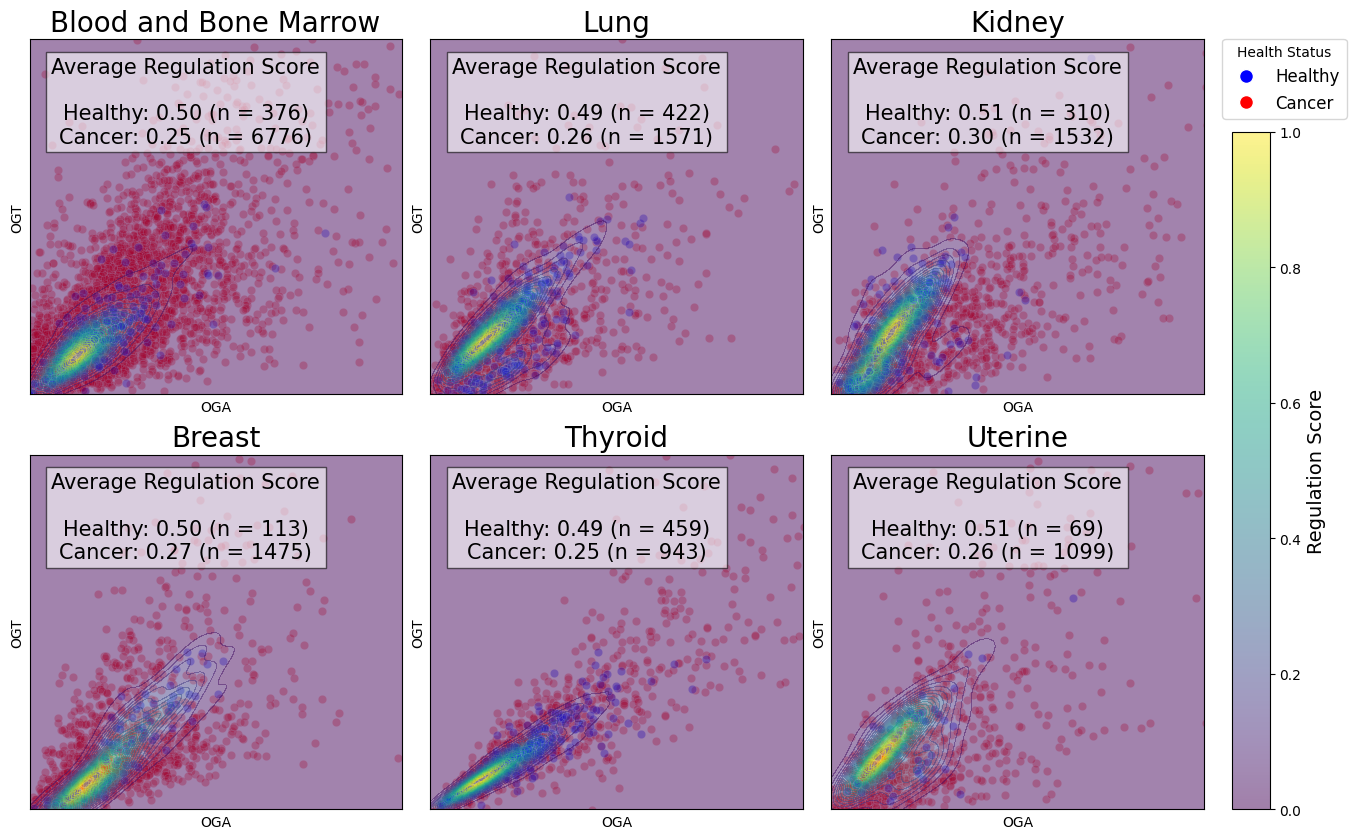

In [8]:
# Plot KDE regulation scores - save figure 1
tcga_metrics = [metrics_tcga_bmb, metrics_tcga_lng, metrics_tcga_kid, metrics_tcga_brs, metrics_tcga_thy, metrics_tcga_utr]
thresholds =   [   threshold_bmb,    threshold_lng,    threshold_kid,    threshold_brs,    threshold_thy,    threshold_utr]

plot_KDE_regulation_scores(tcga_metrics, titles = titles, geo_datasets=None, thresholds=thresholds, label = 'Health_Status',
                           see_through=0.3, zoom_limits=zoom_limits, figsize=(16, 10), save_as = 'Fig1_KDE_Regulation_Score')

In [40]:
print(round(0.5/0.25,2))
print(round(0.49/0.26,1))
print(round(0.51/0.30,1))
print(round(0.5/0.27,1))
print(round(0.49/0.25,1))
print(round(0.51/0.26,1))


2.0
1.9
1.7
1.9
2.0
2.0


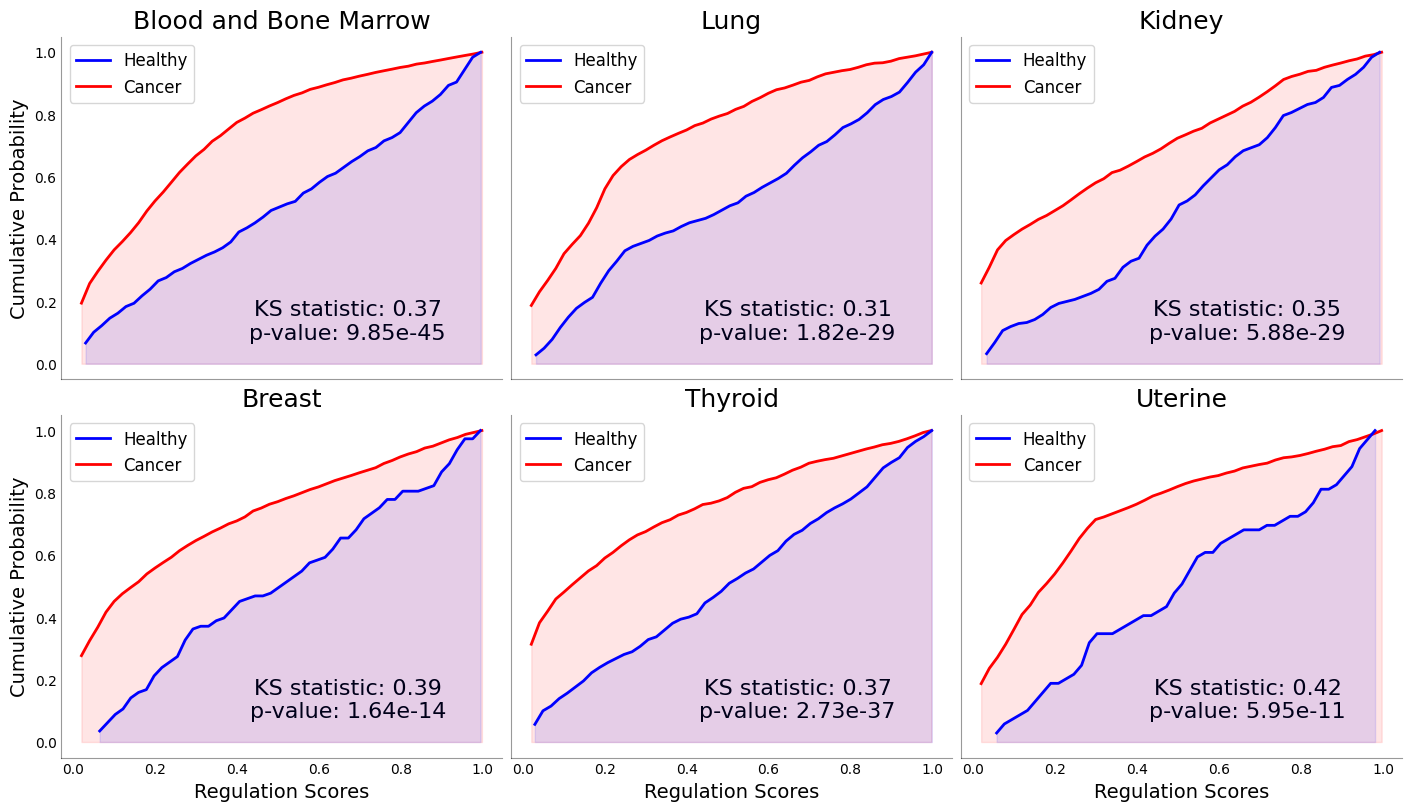

In [57]:
# Plot statistical comparison of dysregulation distributions of KDE regulation scores - save figure 2
KS_stat_results = plot_KDE_distributions(tcga_metrics, titles)

In [10]:
metrics_geo_bmb = generate_GEO_metrics(geo_batch_list[0], tcga_batch_list[0],threshold=threshold_bmb
                                        # ,see_through=0.8, zoom_limits=zoom_limits[0], title=titles[0], plot_toggle=True
                                       )

metrics_geo_lng = generate_GEO_metrics(geo_batch_list[1], tcga_batch_list[1],threshold=threshold_lng
                                        # ,see_through=0.8, zoom_limits=zoom_limits[1], title=titles[1], plot_toggle=True
                                       )

metrics_geo_kid = generate_GEO_metrics(geo_batch_list[2], tcga_batch_list[2],threshold=threshold_kid
                                        # ,see_through=0.8, zoom_limits=zoom_limits[2], title=titles[2], plot_toggle=True
                                       )

metrics_geo_brs = generate_GEO_metrics(geo_batch_list[3], tcga_batch_list[3],threshold=threshold_brs
                                        # ,see_through=0.8, zoom_limits=zoom_limits[3], title=titles[3], plot_toggle=True
                                       )

metrics_geo_thy = generate_GEO_metrics(geo_batch_list[4], tcga_batch_list[4],threshold=threshold_thy
                                        # ,see_through=0.8, zoom_limits=zoom_limits[4], title=titles[4], plot_toggle=True
                                       )

metrics_geo_utr = generate_GEO_metrics(geo_batch_list[5], tcga_batch_list[5],threshold=threshold_utr
                                        # ,see_through=0.8, zoom_limits=zoom_limits[5], title=titles[5], plot_toggle=True
                                       )

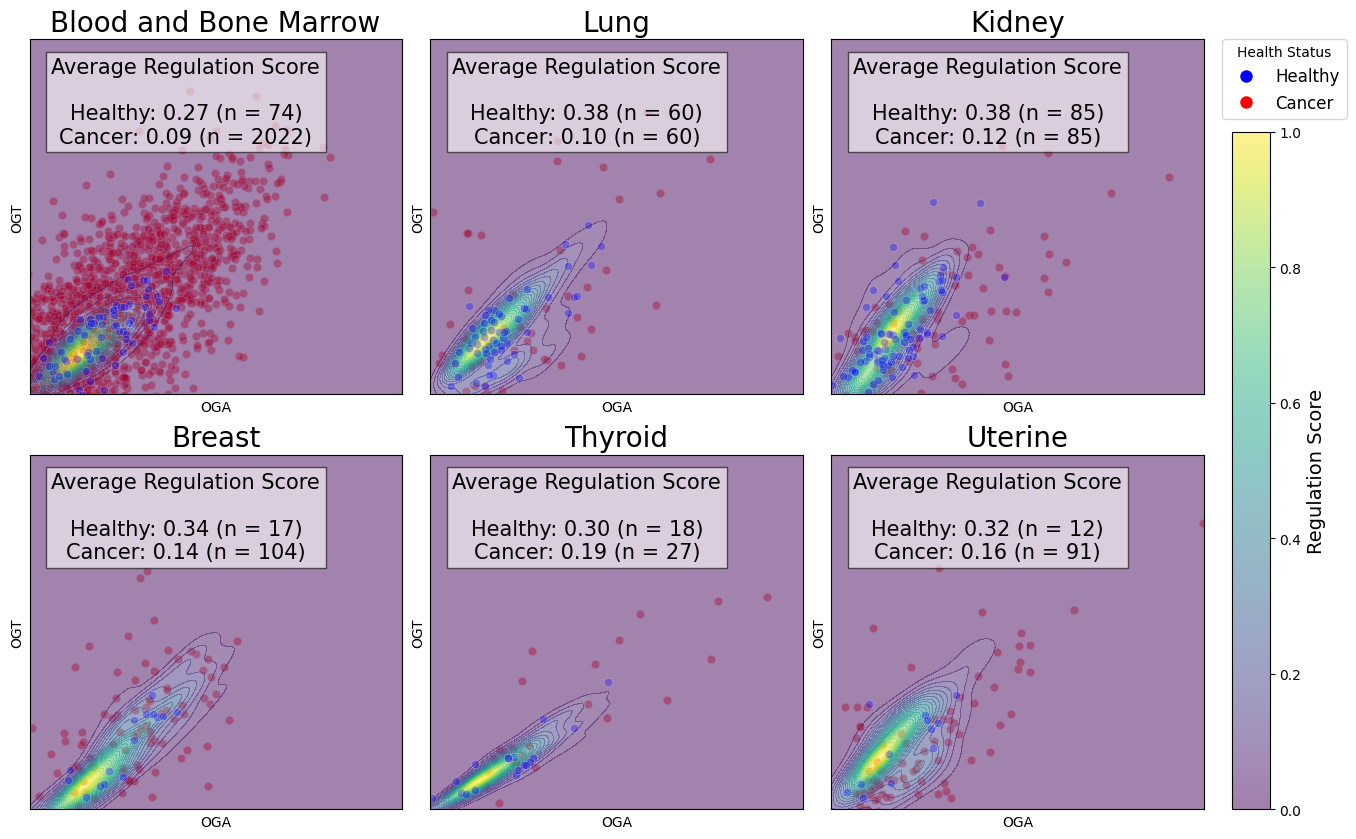

In [11]:
# Plot KDE regulation scores - save figure 1
geo_metrics = [metrics_geo_bmb, metrics_geo_lng, metrics_geo_kid, metrics_geo_brs, metrics_geo_thy, metrics_geo_utr]

plot_KDE_regulation_scores(tcga_metrics, titles, geo_metrics, thresholds, see_through=0.4, label = 'label', 
                           zoom_limits=zoom_limits, save_as = 'Sup1_geo_KDE_Regulation_Scores')

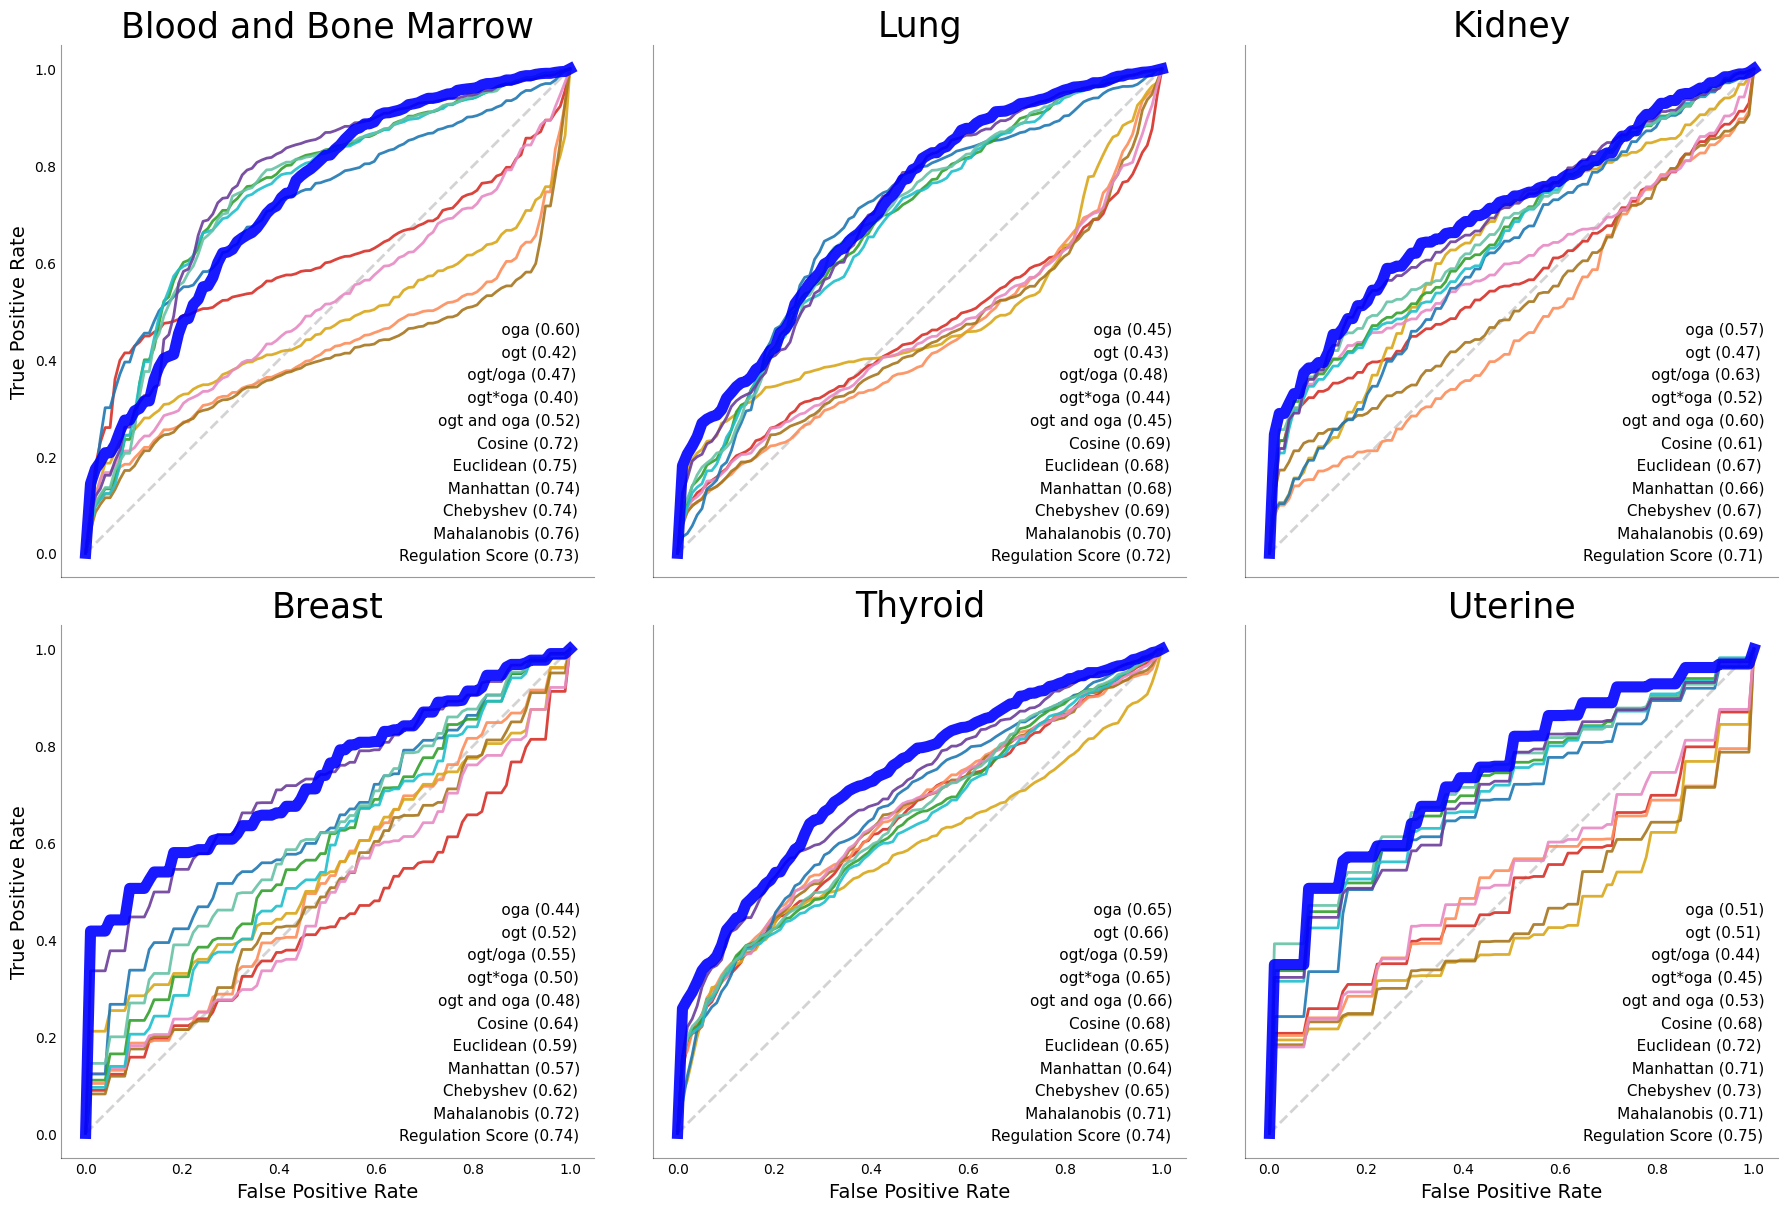

In [29]:


# Prepare the results_dict
results_dict_geo = {
    "Blood and Bone Marrow": metrics_geo_bmb,
    "Lung": metrics_geo_lng,
    "Kidney": metrics_geo_kid,
    "Breast": metrics_geo_brs,
    "Thyroid": metrics_geo_thy,
    "Uterine": metrics_geo_utr,
}

# Prepare the results_dict
results_dict_tcga = {
    "Blood and Bone Marrow": metrics_tcga_bmb,
    "Lung": metrics_tcga_lng,
    "Kidney": metrics_tcga_kid,
    "Breast": metrics_tcga_brs,
    "Thyroid": metrics_tcga_thy,
    "Uterine": metrics_tcga_utr,
}

# Define stratify_by_dict and titles
stratify_by_dict = {
    "Blood and Bone Marrow": 'label',
    "Lung": 'label',
    "Kidney": 'label',
    "Breast": 'label',
    "Thyroid": 'label',
    "Uterine": 'label',
}

titles = ["Blood and Bone Marrow", "Lung", "Kidney", "Breast", "Thyroid", "Uterine"]

# Example usage:
auc_df_tcga = plot_roc_curves_curves(
    results_dict_tcga,
    stratify_by_dict,
    titles,
    n_splits=5,
    save_path='./data/figures/Fig4_ROC_TCGA'
)

In [43]:
auc_df_tcga.mean().round(2)

**Regulation Score**        0.73
       Mahalanobis          0.72
         Chebyshev          0.68
           Euclidean        0.68
                Cosine      0.67
          Manhattan         0.66
        ogt and oga         0.54
                     oga    0.54
              ogt/oga       0.53
                     ogt    0.50
              ogt*oga       0.49
dtype: float64

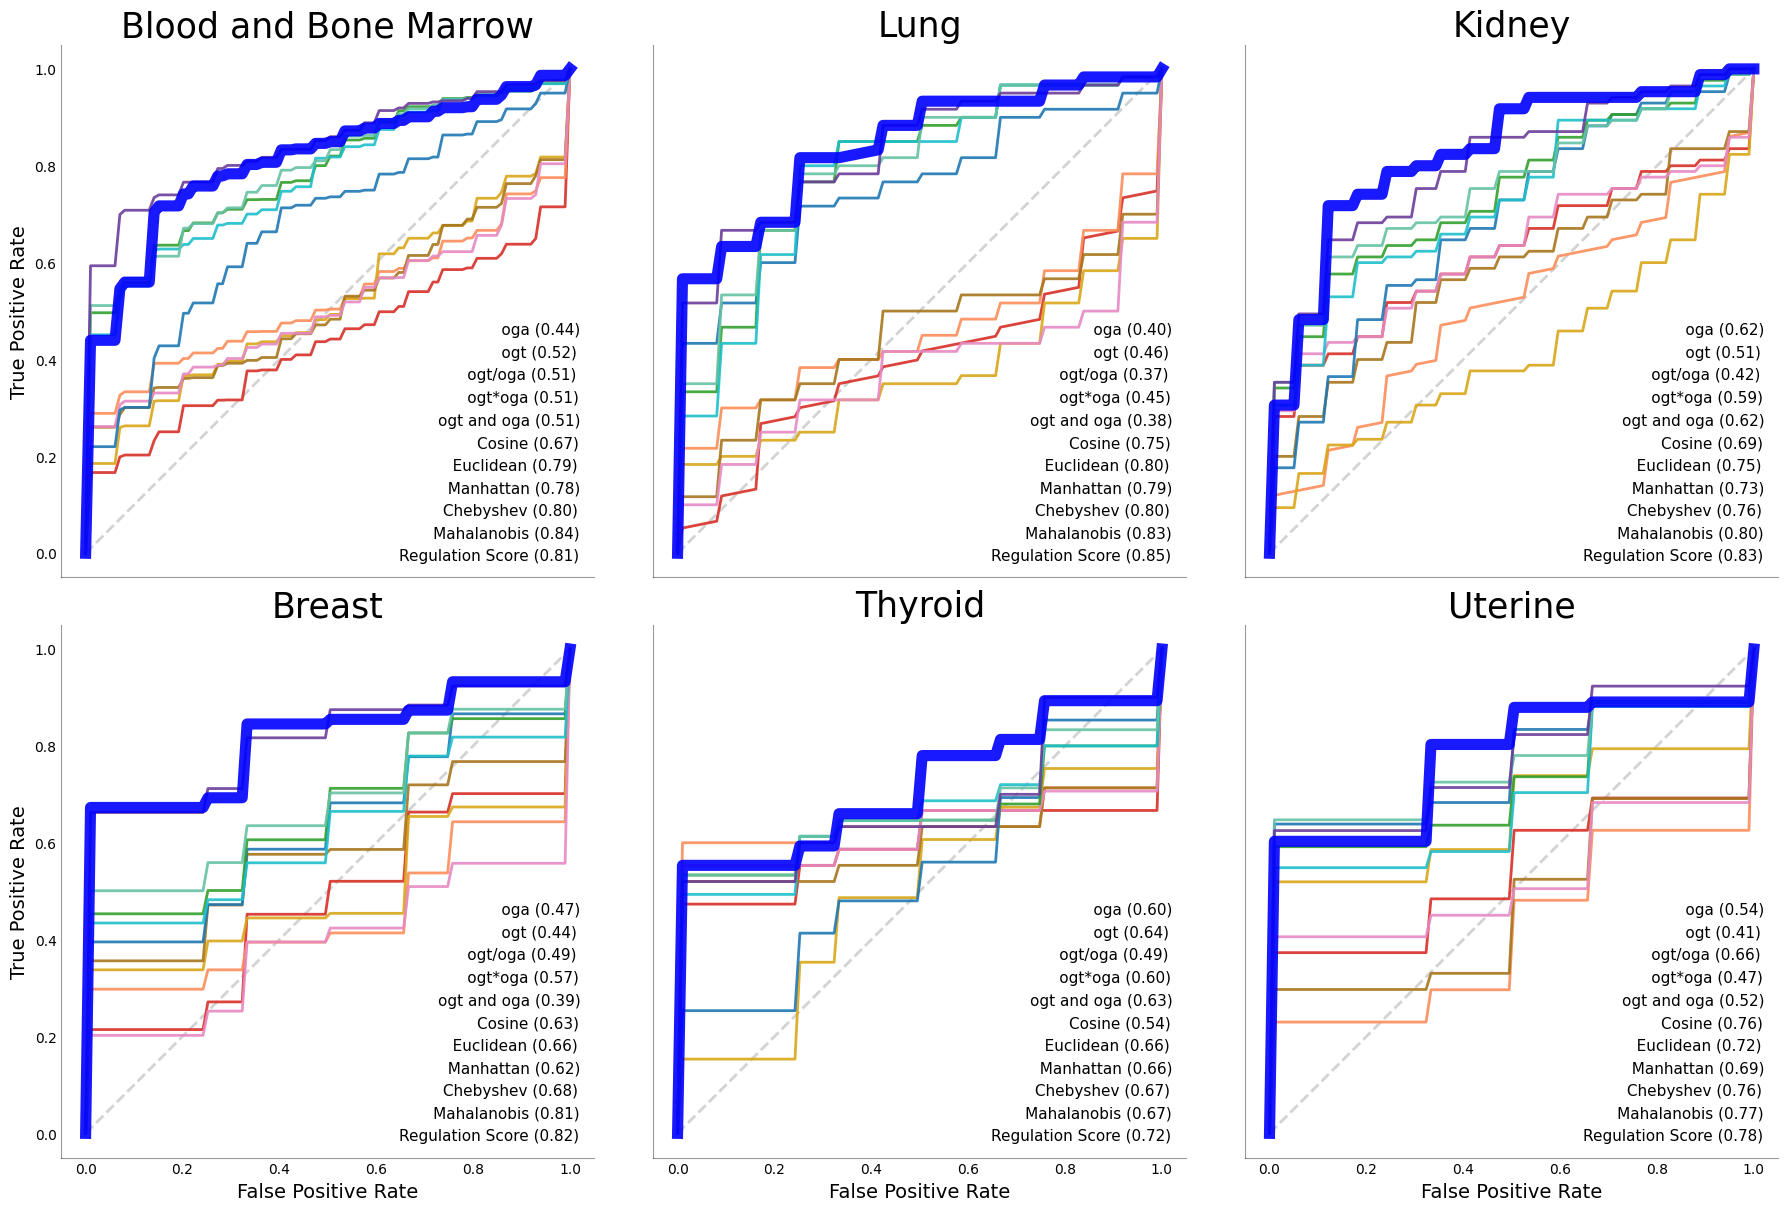

In [19]:
# Example usage:
auc_df = plot_roc_curves_curves(
    results_dict_geo, 
    stratify_by_dict, 
    titles,
    n_splits=5,
    save_path='./data/figures/Fig5_ROC_GEO'
)


In [45]:
auc_df.mean().round(2)

**Regulation Score**        0.80
       Mahalanobis          0.79
         Chebyshev          0.75
           Euclidean        0.73
          Manhattan         0.71
                Cosine      0.68
              ogt*oga       0.53
                     oga    0.51
        ogt and oga         0.51
                     ogt    0.50
              ogt/oga       0.49
dtype: float64